In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import tensorflow as tf
import scipy
import os
import sys
from glob import glob
import cv2 
import time
import datetime

from shutil import copy
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.layers import Input, Dense, Conv2D, Flatten
from tensorflow.keras.optimizers import SGD, Adam
from tensorflow.keras.applications.efficientnet import EfficientNetB0 as  PretrainedModel,preprocess_input

from tensorflow.keras.preprocessing import image
from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [2]:
import tensorflow as tf
tf.__version__

'2.5.0'

In [6]:
# all_images = glob("./images/*/*.jpg")

# print(all_images[1])

./images/position/position_31.jpg


In [7]:
# for im in all_images:
#     im_tmp = cv2.imread(im)[50:100, 150:220]
#     cv2.imwrite(im, im_tmp)

In [90]:
# for idx in range(1,10,1):
#     os.makedirs(f"../digit_recog/images/{idx}/")

In [94]:
# for idx in range(1,10,1):
#     copy(f"../images/references/{idx}.jpg", f"../digit_recog/images/{idx}/{idx}.jpg")

In [98]:
# for im in images:
#     for i in im:
#         for idx in range(100):
#             im_tmp = i.replace(".jpg",f"_{idx}.jpg")
#             copy(i, im_tmp)

In [8]:
from random import sample

folders = [f"../digit_recog/images/{idx}/" for idx in range(1,10,1)]
folders.append("../digit_recog/images/ball/")
folders.append("../digit_recog/images/blank/")
folders.append("../digit_recog/images/marker/")


In [9]:
folders

['../digit_recog/images/1/',
 '../digit_recog/images/2/',
 '../digit_recog/images/3/',
 '../digit_recog/images/4/',
 '../digit_recog/images/5/',
 '../digit_recog/images/6/',
 '../digit_recog/images/7/',
 '../digit_recog/images/8/',
 '../digit_recog/images/9/',
 '../digit_recog/images/ball/',
 '../digit_recog/images/blank/',
 '../digit_recog/images/marker/']

In [10]:
images = [glob(f + '/*.jpg') for f in folders]

In [6]:
from shutil import copy

In [7]:
# for im in images:
#     for i in im:
#         for idx in range(100):
#             im_tmp = i.replace(".jpg",f"_{idx}.jpg")
#             copy(i, im_tmp)

In [12]:
images[11]

['../digit_recog/images/marker/position_25.jpg',
 '../digit_recog/images/marker/position_31.jpg',
 '../digit_recog/images/marker/position_19.jpg',
 '../digit_recog/images/marker/position_7.jpg',
 '../digit_recog/images/marker/position_6.jpg',
 '../digit_recog/images/marker/position_18.jpg',
 '../digit_recog/images/marker/position_30.jpg',
 '../digit_recog/images/marker/position_24.jpg',
 '../digit_recog/images/marker/position_32.jpg',
 '../digit_recog/images/marker/position_26.jpg',
 '../digit_recog/images/marker/position_4.jpg',
 '../digit_recog/images/marker/position_5.jpg',
 '../digit_recog/images/marker/position_27.jpg',
 '../digit_recog/images/marker/position_33.jpg',
 '../digit_recog/images/marker/position_37.jpg',
 '../digit_recog/images/marker/position_23.jpg',
 '../digit_recog/images/marker/position_1.jpg',
 '../digit_recog/images/marker/position_0.jpg',
 '../digit_recog/images/marker/position.jpg',
 '../digit_recog/images/marker/position_22.jpg',
 '../digit_recog/images/marke

In [13]:
ptm = PretrainedModel(
        input_shape = [100,100,3],
        weights = 'imagenet',
        include_top = False

)

2023-01-08 16:39:04.027767: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [14]:
ptm.trainable = False
K = len(folders)

x = Flatten()(ptm.output)
x = Dense(K, activation = 'softmax')(x)

In [15]:
model = Model(inputs = ptm.input , outputs = x)
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 100, 100, 3) 0                                            
__________________________________________________________________________________________________
rescaling (Rescaling)           (None, 100, 100, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
normalization (Normalization)   (None, 100, 100, 3)  7           rescaling[0][0]                  
__________________________________________________________________________________________________
stem_conv_pad (ZeroPadding2D)   (None, 101, 101, 3)  0           normalization[0][0]              
______________________________________________________________________________________________

In [16]:
gen = ImageDataGenerator(
        width_shift_range = 0.1,
        height_shift_range = 0.1,
        shear_range = 0.1,
        zoom_range = 0.2,
        horizontal_flip = False,
        preprocessing_function = preprocess_input
)


In [17]:
batch_size = 64


In [18]:
IMAGE_SIZE = [100,100]

In [19]:
train_generator = gen.flow_from_directory(      
    "../digit_recog/images",
    shuffle = True,
    target_size = IMAGE_SIZE,
    batch_size = batch_size
    )

test_generator = gen.flow_from_directory(
    "../digit_recog/images",
    target_size = IMAGE_SIZE,
    batch_size = batch_size
)


Found 1212 images belonging to 12 classes.
Found 1212 images belonging to 12 classes.


In [20]:
model.compile(loss = 'categorical_crossentropy' , optimizer = 'adam' , metrics = ['accuracy'])


In [21]:
acc_thresh = 0.985
class myCallback(tf.keras.callbacks.Callback):
    def on_epoch_end(self,epoch,logs={}):
        if(logs.get('accuracy') > acc_thresh):
            print("Stopping training as desired accuracy reached....")
            self.model.stop_training = True


In [22]:
myCall = myCallback()

In [23]:
image_files = glob("../digit_recog/images/*/*.jpg")
test_image_files = glob("../digit_recog/images/*/*.jpg")

In [24]:
r = model.fit(
        train_generator,
        validation_data = test_generator,
        epochs = 2,
        steps_per_epoch = int(np.ceil(len(image_files)/batch_size)),
        validation_steps = int(np.ceil(len(test_image_files)/batch_size)),
        callbacks=[myCall]
)

2023-01-08 16:39:51.023766: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:176] None of the MLIR Optimization Passes are enabled (registered 2)


Epoch 1/2
19/19 [==============================] - 29s 1s/step - loss: 0.3246 - accuracy: 0.9026 - val_loss: 8.2902e-04 - val_accuracy: 1.0000
Epoch 2/2
19/19 [==============================] - 18s 985ms/step - loss: 0.0025 - accuracy: 0.9992 - val_loss: 2.1664e-05 - val_accuracy: 1.0000
Stopping training as desired accuracy reached....


In [35]:
model.save("./models/model.h5")

/Users/raprak-blrm20/opt/anaconda3/envs/RL/lib/python3.9/site-packages/tensorflow/python/keras/utils/generic_utils.py:494: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  warnings.warn('Custom mask layers require a config and must override '


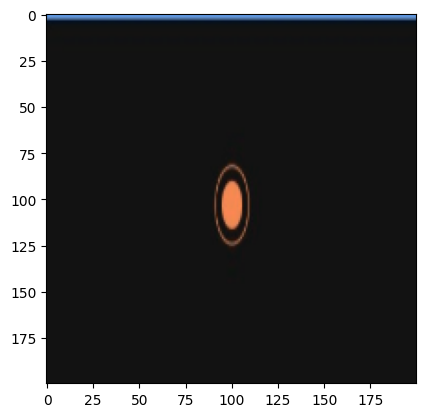

In [29]:
plt.imshow(image)

In [27]:
image = cv2.imread("./images/ball/ball_0.jpg")
image = cv2.resize(image, (100,100))
image = image.reshape(1,100,100,3)
np.argmax(model.predict(image))

9

In [29]:
image = cv2.imread("./images/marker/position_0.jpg")
image = cv2.resize(image, (100,100))
image = image.reshape(1,100,100,3)
np.argmax(model.predict(image))

11

In [41]:
model.predict(image)

array([[2.5532077e-24, 2.9006976e-33, 6.3214678e-24, 2.2793293e-26,
        4.2398168e-28, 1.3275864e-24, 1.3093683e-26, 7.7039351e-18,
        1.2904387e-22, 7.0954002e-21, 1.1085082e-24, 1.0000000e+00]],
      dtype=float32)

In [36]:
image = cv2.imread("/Users/raprak-blrm20/Desktop/personal/CODES/m-projects/a-games/wallsmash_cracker/images/boxes8/patch_12.jpg")[50:100, 150:220]
image = cv2.resize(image, (100,100))
image = image.reshape(1,100,100,3)
np.argmax(model.predict(image))

9

In [33]:
model.predict(image)

array([[9.1438502e-04, 9.7156217e-06, 1.2626368e-02, 9.7666895e-03,
        1.2845389e-04, 8.3884521e-04, 1.6647694e-04, 4.9429394e-02,
        8.3650294e-04, 4.0192235e-01, 1.2267102e-02, 5.1109368e-01]],
      dtype=float32)

In [31]:
model = load_model("./models/model.h5")